In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats

# Description

Say we have sampled values of something we are interested in. We decide model the value `Y` as a normal distribution centered around an unknown `weight` and a standard deviation of `2`: `P(Y | weight) = N(weight, 2)`. This is called the likelihood. Our initial guess for the distribution of the weight itself will be `N(0, 2)` and this is called the prior. The values of this model are chosen somewhat arbitrarily. They can be chosen more accurately (ie. smaller standard deviations) if we have a good guess about the distribution of Y. Given only samples of `Y` how do we figure out the value of `weight` that likely produced these samples and give some bounds on `weight`?

# 1. Sample data generation

Let's start by generating some example data. We choose our ground truth `weight` to be `-1` and our standard deviation for Y to be 1. Y is then `N(-1, 1)`. Let's create some samples from Y. We will use these later to figure out the original weight from just these samples and the model.

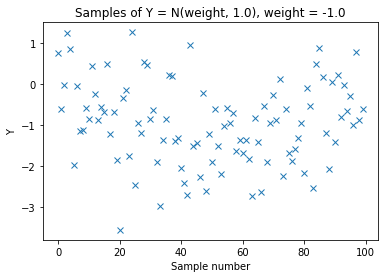

In [2]:
# Ground truth weight
gt_weight = -1

# Ground truth Y distribution: N(weight, 1)
gt_y_std = 1

# Draw samples from ground truth Y distribution
num_gts = 100

gt_y = np.empty(num_gts, dtype=np.float32)
np.random.seed(0)
for i in range(num_gts):
    # Sample y from N(weight, 1)
    gt_y[i] = np.random.normal(loc=gt_weight, scale=gt_y_std)

# Plot samples
plt.title("Samples of Y = N(weight, %.1f), weight = %.1f" % (gt_y_std, gt_weight))
plt.xlabel("Sample number")
plt.ylabel("Y")
plt.plot(gt_y, linestyle="None", marker="x")
plt.show()

# 2. Use Metropolis-Hastings to get samples of weights under the given Y

Bayes theorem states that the distribution of `weight` given `Y` can be calculated: `P(weight | Y) = P(Y | weight) * P(weight) / P(Y)`. With the above model we can already calculate `P(Y | weight)` and `P(weight)`.
For example assume we defined a prior `P(weight) = N(0, 2)` and a likelihood function `P(Y | weight) = N(weight, 2)`. If we have `weight = 0.5` we can calculate its prior probability `P(weight) = P(0.5) = N(0.5 | 0, 2) = 0.19`. Furthermore if we have some samples `Y = [-1, -0.5, 1]` we can calculate their probability given the weight and the likelihood function `P(Y | weight) = N(-1 | 0.5, 2) * N(-0.5 | 0.5, 2) * N(1 | 0.5, 2) = 0.15 * 0.18 * 0.20 = 0.0054`. The joint probability is then `P(Y | weight) * P(weight) = 0.0054 * 0.19 = 0.0010`. However we don't have the denominator `P(Y)` and while `P(Y)` could be calculated by integrating `P(Y | weight)` over all possible weights this is not possible in practice.
What we can do instead is use a sampling algorithm to get samples from `P(weight | Y)`. After taking enough samples we should see the shape of distribution by plotting a histogram of the samples. One such sampling algorithm is the Metropolis-Hastings algorithm. It keeps a list of samples for the weights for each step. An arbitrary initial value for weight is chosen. A new weight around the old one is calculated for example by sampling from `N(weight, 1)`. Then a rejection ratio is calculated from the joint probabilities of the old and the new weight under the given Y. These are calculated like in the example before. The rejection ratio is then `r = NewJointProb / OldJointProb`. We then we decide to keep the new weight sample if `r` is greater than a random sample from `U(0, 1)` which means we are likely to keep weight samples that have a higher joint probability. In the end we will have samples of weights whose distribution approximates `P(weight | Y)`. The more samples of Y we have, the more accurately we will know the value of weight as this distribution will have a smaller standard deviation.

TL;DR:
- Weight prior: `P(weight) = N(0, 2)`
- Likelihood of Y given weight: `P(Y | weight) = N(weight, 2)`
- Figure out the distribution of `weight` given observed Y samples by sampling from `P(weight | Y)` using Metropolis-Hastings which uses only the given `Y` samples, `P(weight)` and `P(Y | weight)`
- The more Y samples we have, the more we can pin down the value of the weight (ie. the distribution's standard deviation goes down)

An important detail for doing this numerically is that as seen above when calculating `P(Y | weight)` we multiply a lot of small values together, so doing it naively would not work. Instead we operate on log probabilities where multiplication becomes addition and later convert back to probabilities by exponentiating. Furthermore we also throw away the initial samples ("burn in") as these are bad values used for initializing the algorithm since we start from the arbitrary value of 0 and we need to get to reasonable values first.

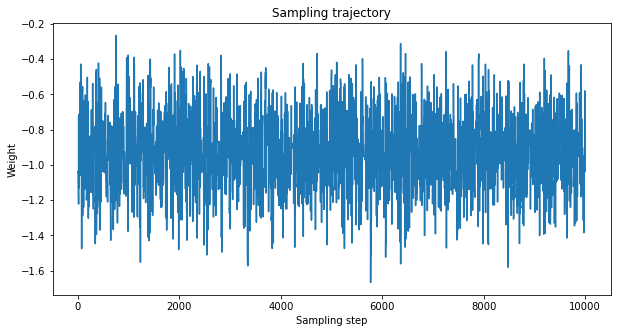

In [3]:
# P(weight) = N(0, 2)
prior_weight_mean = 0
prior_weight_std = 2
prior_weight = scipy.stats.norm(prior_weight_mean, prior_weight_std)

# P(y | weight) = N(weight, 2)
likelihood_std = 2

# We use logarithmic probabilities everywhere since multiplying so many
# small numbers together doesn't work numerically.

def calculate_log_joint_prob(weight):
    """Calculate log(P(y | weight) * P(weight)) = log_P(y | weight) + log_P(weight)."""
    # log_P(weight) = N(0, 2)
    log_p_weight = prior_weight.logpdf(weight)

    # log_P(y | weight) = N(y | weight, 2)
    log_p_likelihood = np.sum(scipy.stats.norm(weight, likelihood_std).logpdf(gt_y))

    # log_P(y | weight) + log_P(weight)
    return log_p_likelihood + log_p_weight

def should_accept(joint_log_prob_new, joint_log_prob_old):
    """Compare the joint probabilities of two weights and return
    whether the new weight should be kept.
    r = (P(y | new_weight) * P(new_weight)) / (P(y | old_weight) * P(old_weight))
    Accept new weight if r > sample from U(0, 1).
    """
    return joint_log_prob_new - joint_log_prob_old > np.log(np.random.uniform())

def next_sample(weight_old):
    """Calculate next sample using N(weight_old, 1)"""
    return np.random.normal(loc=weight_old, scale=1)

np.random.seed(0)

num_samples = 10000
num_burn_in = 10000

samples = np.empty(num_samples, dtype=np.float32)

# Set initial weight to 0 and calculate its joint probability
weight = 0
joint_log_prob = calculate_log_joint_prob(weight)

# Draw some samples using Metropolis-Hastings
for i in range(num_samples + num_burn_in):
    # Get the next weight and calculate its joint probability
    next_weight = next_sample(weight)
    next_joint_log_prob = calculate_log_joint_prob(next_weight)

    # Check if we should keep the old or the new weight
    if should_accept(next_joint_log_prob, joint_log_prob):
        weight = next_weight
        joint_log_prob = next_joint_log_prob

    # Throw away the first samples as they are used for initialization
    if i >= num_burn_in:
        # Add weight to samples (will be either the previous one or the new one)
        samples[i - num_burn_in] = weight

# Plot the sampling trajectory
plt.figure(figsize=[10, 5])
plt.xlabel("Sampling step")
plt.ylabel("Weight")
plt.title("Sampling trajectory")
plt.plot(samples)
plt.show()

# 3. Plot histograms of weight samples which will approximate P(weight | Y)

When we now plot the histogram of the weight samples we can see that the more samples we take, the better we can see the distribution. The mean of this distribution should be close to our actual weight of `-1`. Note that if we had more samples of Y, the standard deviation would shrink as we could be more certain about the value of the weight.

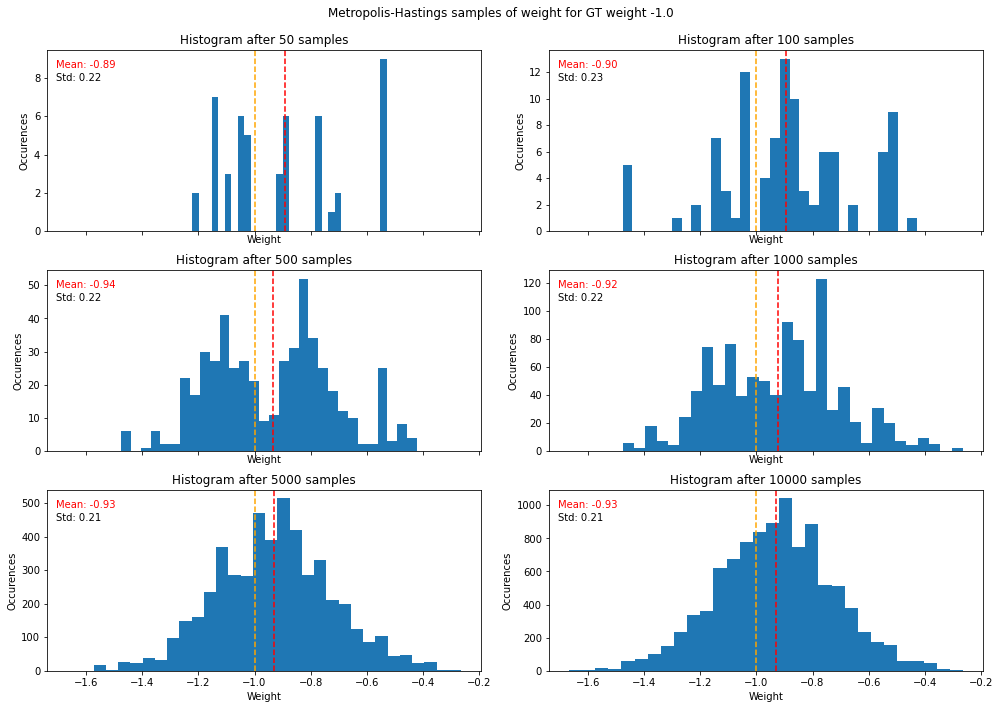

In [4]:
fig, axes = plt.subplots(3, 2, sharex=True, figsize=[14, 10])
fig.suptitle("Metropolis-Hastings samples of weight for GT weight %.1f" % gt_weight)
for i, sample_count in enumerate([50, 100, 500, 1000, 5000, 10000]):
    samples_subset = samples[:sample_count]
    ax = axes[i // 2, i % 2]
    ax.hist(samples_subset, bins=30)
    ax.axvline(gt_weight, c="orange", linestyle="dashed")
    ax.axvline(np.mean(samples_subset), c="red", linestyle="dashed")
    ax.set_title("Histogram after %d samples" % sample_count)
    ax.set_xlabel("Weight")
    ax.set_ylabel("Occurences")
    ax.annotate("Mean: %.2f" % np.mean(samples_subset), [0.02, 0.9], xycoords="axes fraction", c="red")
    ax.annotate("Std: %.2f" % np.std(samples_subset), [0.02, 0.83], xycoords="axes fraction")
fig.tight_layout()
fig.subplots_adjust(top=0.92)
fig.show()

# 4. Plot Y values using our model

Now that we have a distribution for our weights under the data we can also generate new data. The spread of the generated data will be bigger than the spread of the original data since we have some uncertainty in our knowledge of the weight. Finally we can also calculate the 95% confidence interval for our weight distribution wherein 95% of its values will lie.

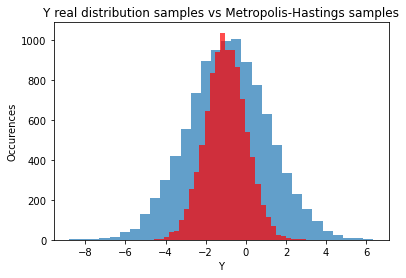

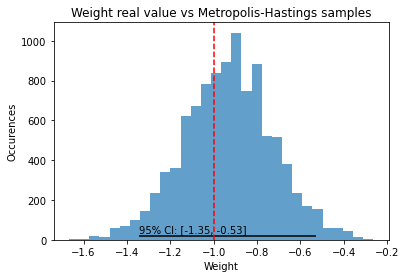

In [6]:
met_y_samples = []
gt_y_samples = []

met_weight_samples = []
met_weight_mean = np.mean(samples)
met_weight_std = np.std(samples)

for i in range(10000):
    gt_y_samples.append(np.random.normal(loc=gt_weight, scale=gt_y_std))
    met_weight_samples.append(np.random.normal(met_weight_mean, met_weight_std))
    met_y_samples.append(np.random.normal(met_weight_samples[-1], likelihood_std))

plt.xlabel("Y")
plt.ylabel("Occurences")
plt.title("Y real distribution samples vs Metropolis-Hastings samples")
plt.hist(met_y_samples, bins=30, alpha=0.7)
plt.hist(gt_y_samples, color="red", alpha=0.7, bins=30)
plt.show()

quantiles = np.quantile(samples, [0.025, 0.975])

plt.xlabel("Weight")
plt.ylabel("Occurences")
plt.title("Weight real value vs Metropolis-Hastings samples")
plt.hist(samples, bins=30, alpha=0.7)
plt.axvline(gt_weight, c="red", linestyle="dashed")
plt.annotate("95%% CI: [%.2f, %.2f]" % (quantiles[0], quantiles[1]), [quantiles[0], 40])
plt.hlines(20, quantiles[0], quantiles[1])
plt.show()